In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


from datetime import datetime

def get_timestamp() -> str:
    timestamp = datetime.now().strftime("%Y_%m_%d_%H_%M_%S")
    return timestamp
import cv2

In [20]:

# Path to the data directory
# data_dir = Path("./captcha_images_v2/")
# data_dir = Path("./crop/")
data_dir = Path("./dammy_color//")

# Get list of all the images
# images = sorted(list(map(str, list(data_dir.glob("*.png")))))
images = sorted(list(map(str, list(data_dir.glob("*.jpg")))))
# labels = [img.split(os.path.sep)[-1].split(".jpg")[0][5:] for img in images]
labels = [img.split(os.path.sep)[-1].split(".jpg")[0] for img in images]
# print(labels)
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
# print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 64

# Desired image dimensions
img_width = 512
img_height = 64

# Factor by which the image is going to be downsampled
# by the convolutional blocks. We will be using two
# convolution blocks and each block will have
# a pooling layer which downsample the features by a factor of 2.
# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])


Number of images found:  100000
Number of labels found:  100000
Number of unique characters:  1513


In [21]:
char2id = {}
id2char = {}
# for i,x in enumerate(list(characters)):
#     char2id[x] = i
    
# # print(char2id)
# for i,x in enumerate(list(characters)):
#     id2char[i] = x

import pickle
with open('./id2char.pkl','rb') as p:
    id2char = pickle.load(p)

with open('./char2id.pkl','rb') as p:
    char2id = pickle.load(p)

print(id2char)

def char_to_num(char):
#     res=[]
    res = np.ones(64) - 2
    for i,c in enumerate(char):
#         print(c)
#         res.append(char2id[c])
        res[i] = char2id[c]
    return res

def num_to_char(num):
    res = []
    for n in num.numpy():
        if n in id2char.keys():
            res.append(id2char[n])
        else:
            res.append('?')
    return res


def split_data(images, labels, train_size=0.9, shuffle=True):
    # 1. Get the total size of the dataset
    size = len(images) 
    # 2. Make an indices array and shuffle it, if required
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    # 3. Get the size of training samples
    train_samples = int(size * train_size)
    # 4. Split data into training and validation sets
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
#     return x_train[0:1], x_valid[0:1], y_train[0:1], y_valid[0:1]
    return x_train, x_valid, y_train, y_valid



# Splitting data into training and validation sets
x_train, x_valid, c_train, c_valid = split_data(np.array(images), np.array(labels))

y_train=[]
for i in c_train:
    y_train.append(char_to_num(i))
# y_train = np.array(y_train,dtype=np.int32)
# y_valid=[]
# for i in c_valid:
#     y_valid.append(char_to_num(i))
# y_valid = np.array(y_valid,dtype=np.int32)
# y_train


y_valid=[]
for i in c_valid:
#     break
    y_valid.append(char_to_num(i))

# y_train

{0: '骨', 1: '専', 2: '理', 3: 'ダ', 4: 'l', 5: '協', 6: '爆', 7: '前', 8: '郵', 9: '語', 10: '閥', 11: '普', 12: '遺', 13: '育', 14: '子', 15: '満', 16: '矢', 17: '罰', 18: '袋', 19: 'ク', 20: '身', 21: '片', 22: '税', 23: '宅', 24: '記', 25: '郷', 26: '級', 27: '歴', 28: 'せ', 29: '芝', 30: '地', 31: '底', 32: 'オ', 33: '岡', 34: '海', 35: '私', 36: '測', 37: '振', 38: '配', 39: '唯', 40: '酒', 41: '似', 42: '験', 43: '安', 44: '港', 45: '核', 46: '浜', 47: '迷', 48: '華', 49: '筆', 50: '志', 51: '角', 52: 'プ', 53: '感', 54: '沢', 55: 'キ', 56: '議', 57: 'ギ', 58: '登', 59: '名', 60: '被', 61: '毎', 62: '梅', 63: '単', 64: '促', 65: '種', 66: '急', 67: '泊', 68: 'ぜ', 69: '鎖', 70: 'メ', 71: '3', 72: '管', 73: '替', 74: '近', 75: '役', 76: 'ヅ', 77: '同', 78: '儀', 79: 'ニ', 80: 'さ', 81: '器', 82: '吹', 83: 'サ', 84: '芸', 85: '申', 86: '勧', 87: 'ド', 88: '却', 89: '野', 90: '買', 91: '資', 92: '払', 93: '航', 94: '範', 95: '位', 96: '隠', 97: '今', 98: '模', 99: '会', 100: '想', 101: '集', 102: 'ノ', 103: '茨', 104: '意', 105: '膨', 106: '土', 107: '試', 108: '析', 109: 'コ', 110: '渡',

In [22]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=3)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
#     img = tf.image.resize(img, [img_height, img_width])
    img = tf.image.random_crop(img,(img_height, img_width,3))
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image.
#     img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    lb_len = tf.reduce_sum(tf.cast(tf.not_equal(label, -1), tf.int64))
#     label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label,"label_len": lb_len}

In [23]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(
        encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE
    )
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

(64,)
tf.Tensor(15, shape=(), dtype=int64)
反喜男夫縦休耐化声増使観因構訓?????????????????????????????????????????????????


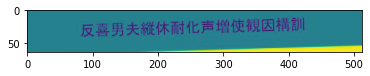

(64,)
tf.Tensor(12, shape=(), dtype=int64)
館市覇降投違明熱抵き顔探????????????????????????????????????????????????????


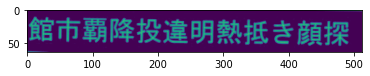

(64,)
tf.Tensor(8, shape=(), dtype=int64)
規1療是志哲威言????????????????????????????????????????????????????????


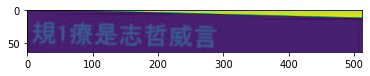

(64,)
tf.Tensor(10, shape=(), dtype=int64)
判送埋生舎備党戻奈庭??????????????????????????????????????????????????????


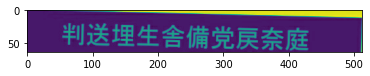

(64,)
tf.Tensor(14, shape=(), dtype=int64)
翌英弱像e俊づ即境協線松q諸??????????????????????????????????????????????????


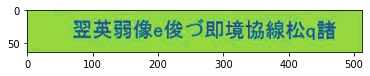

(64,)
tf.Tensor(15, shape=(), dtype=int64)
息日き校率依検壁寝す衆紹賄歯東?????????????????????????????????????????????????


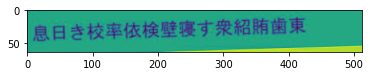

(64,)
tf.Tensor(7, shape=(), dtype=int64)
症容g評脳田近?????????????????????????????????????????????????????????


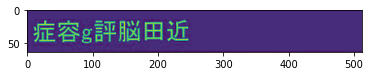

(64,)
tf.Tensor(11, shape=(), dtype=int64)
図五狙ず未芸ボ考寝島ペ?????????????????????????????????????????????????????


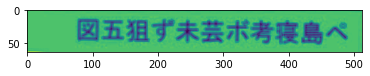

(64,)
tf.Tensor(12, shape=(), dtype=int64)
抵味易ポ祉課の銭北秩類柳????????????????????????????????????????????????????


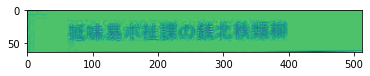

(64,)
tf.Tensor(9, shape=(), dtype=int64)
較印量影泳調辞種比???????????????????????????????????????????????????????


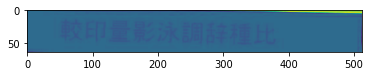

In [24]:
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    
    label_len = batch["label_len"]
    for i in range(10):
        img = (images[i]).numpy().astype("float32")
#         print(labels[i])
#         print(labels[i].numpy())
        print(labels[i].numpy().shape)
        print(label_len[i])
        label = ''.join(num_to_char(labels[i]))
        print(label)
#         plt.imshow(img[:, :, 0], cmap="gray")
        plt.imshow(img[:, :, 0])
        plt.show()

In [25]:
config = {
#     "alpha": 1.0,
#     "minimalistic": True,
    "weights": "imagenet",
    "weights": None,
    "include_top": False
}


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred,label_len):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(label_len, dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        # At test time, just return the computed predictions
        return y_pred

def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_height,img_width,3), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")
    label_len = layers.Input(name="label_len", shape=(None,), dtype="float32")
    
    
    x = keras.applications.resnet50.ResNet50(input_tensor=input_img, **config).get_layer('conv2_block3_out').output

    x = layers.MaxPooling2D((2, 2), name="pool3")(x)

    print(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    print(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Conv2D(32,(8,1),activation="relu",kernel_initializer="he_normal")(x)
    x = layers.Lambda(lambda x: tf.squeeze(x,1),name='logits')(x)
    print(x)

    # RNNs
#     x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
#     x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)
    # Output layer
    x = layers.Dense(
        len(characters)+1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x,label_len)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels, label_len ], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 8, 64, 256), dtype=tf.float32, name=None), name='pool3/MaxPool:0', description="created by layer 'pool3'")
KerasTensor(type_spec=TensorSpec(shape=(None, 8, 64, 64), dtype=tf.float32, name=None), name='dense1/Relu:0', description="created by layer 'dense1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 64, 32), dtype=tf.float32, name=None), name='logits/Squeeze:0', description="created by layer 'logits'")
Model: "ocr_model_v1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 64, 512, 3)] 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 70, 518, 3)   0           image[0][0]                      
____________________________

In [44]:
# workspace/dense.release/svt1/2021_11_05_05_15_13.ckpt.index
# workspace/dense.release/svt1/2021_11_06_18_13_47.ckpt.index
model.load_weights('2021_11_08_02_43_54transfer.ckpt')

In [31]:
epochs = 10
early_stopping_patience = 3

filepath = get_timestamp() + 'transfer.ckpt'
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True, mode='auto', period=1)

# Add early stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping,checkpoint],
#     callbacks=[checkpoint],
)

Epoch 1/10
1407/1407 [==============================] - 1699s 1s/step - loss: 14.2535 - val_loss: 6.8281

Epoch 00001: val_loss improved from inf to 6.82805, saving model to 2021_11_08_02_43_54transfer.ckpt
Epoch 2/10
1407/1407 [==============================] - 1696s 1s/step - loss: 4.2228 - val_loss: 3.4024

Epoch 00002: val_loss improved from 6.82805 to 3.40244, saving model to 2021_11_08_02_43_54transfer.ckpt
Epoch 3/10
1407/1407 [==============================] - 1703s 1s/step - loss: 2.8726 - val_loss: 4.8134

Epoch 00003: val_loss did not improve from 3.40244
Epoch 4/10
1407/1407 [==============================] - 1698s 1s/step - loss: 2.3450 - val_loss: 4.0518

Epoch 00004: val_loss did not improve from 3.40244
Epoch 5/10
1407/1407 [==============================] - 1700s 1s/step - loss: 2.1293 - val_loss: 2.1430

Epoch 00005: val_loss improved from 3.40244 to 2.14297, saving model to 2021_11_08_02_43_54transfer.ckpt
Epoch 6/10
1407/1407 [==============================] - 1700s

KeyboardInterrupt: 

In [53]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, keras.layers.Softmax()(model.get_layer(name="dense2").output)
    # model.get_layer(name="image").input, model.get_layer(name="separable_conv2d_1").output
)

(64, 64, 512, 3)


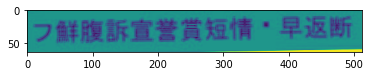

['フ鮮腹訴宣誉賞短借ヸ早返断???????????????????????????????????????????????????', '記月像祖改停温笑八0訪緊久れ担聞茶候倒?????????????????????????????????????????????', '血好括遊番災双J????????????????????????????????????????????????????????', '賄聖r屋替重崎d分招??????????????????????????????????????????????????????', '谷エ替雪江JM届波火??????????????????????????????????????????????????????', '改由パ邸ジ核証ウ存3秀渉洗譲業完????????????????????????????????????????????????', '訴核V担ネ妻メ塾計貿渉好舎先??????????????????????????????????????????????????', '旗意銭哲弱倉講ひヒ一??????????????????????????????????????????????????????', '文線陣徴縄収ろ船規弱秒侵辺天善固????????????????????????????????????????????????', '価非甘朝都波柔ず繰こ打鋼????????????????????????????????????????????????????', '算直塁支阪道初?????????????????????????????????????????????????????????', '温済夕票め項上負漁エ房資車け??????????????????????????????????????????????????', '績章損欲号購台モ両智泉?????????????????????????????????????????????????????', '命見普新残ネ煕高治績??????????????????????????????????????????????????????', 'さ臨ウ都T魅ごザ斎関翼げI家輝???????????????????????????????

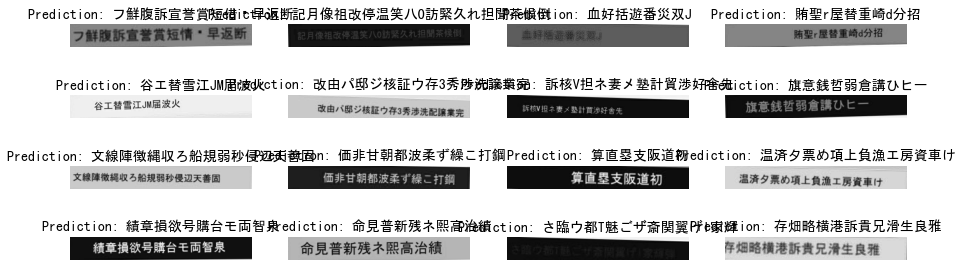

In [54]:
from matplotlib.font_manager import FontProperties

fp = FontProperties(fname ='./msg.ttf',size =14)

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
#     input_len = np.ones(pred.shape[0]) * 13
    # Use greedload_weightsarch. For complex tasks, you can use beam search
#     print(input_len)
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]
    print(batch_images.shape)
    plt.imshow(batch_images[0,...,0].numpy())
    plt.show()
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
#     print(pred.shape)
    print(pred_texts)
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
#     for i in range(len(pred_texts)):
    for i in range(16):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img
        title = f"Prediction: {pred_texts[i]}"
        title = title.replace('?','')
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title, fontproperties=fp)
        ax[i // 4, i % 4].axis("off")
plt.show()

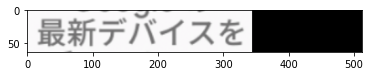

['最新消イスを十L????????????????????????????????????????????????????????']

In [67]:
# workspace/dense.release/svt1/photo_2021-10-29_00-41-41.jpg
# workspace/dense.release/svt1/Screenshot from 2021-11-01 16-16-36.png
# workspace/dense.release/svt1/photo_2021-10-29_00-41-41.jpg
# workspace/dense.release/svt1/Screenshot from 2021-11-01 18-11-57.png
# workspace/dense.release/svt1/photo_2021-11-06_16-41-26.jpg
# workspace/dense.release/svt1/Screenshot from 2021-11-08 17-58-38.png
img = cv2.imread('Screenshot from 2021-11-08 17-58-38.png')
def resize_pad(img, h, w):
    w_new = int(h / img.shape[0] * img.shape[1])
    img = cv2.resize(img, (w_new, h), cv2.INTER_AREA)
    if img.shape[1] >= w: return img[:, :w], w // 16
    padded = np.zeros((h, w, 3)).astype(img.dtype)
    padded[:, :img.shape[1]] = img
    return padded, img.shape[1] // 16
# img = cv2.resize(img,(200,64))

# pad[:img.shape[0],:img.shape[1]] = img
# img = pad
# plt.imshow(img)
# plt.show()
# img = cv2.cvtColor(img,cv2.COLOR_BAYER_BG2RGB)
# plt.imshow(img[:,0:290])
# img = img[:,0:290]
img,_ = resize_pad(img,64,512)
# img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
# img[img>200] = 255>
# img[img<200] = 0
plt.imshow(img)
plt.show()
img = img[np.newaxis,...].astype(np.float64) /255
preds = prediction_model.predict(img)
pred_texts = decode_batch_predictions(preds)

pred_texts

['東京メト口???????????????????????????????????????????????????????????']

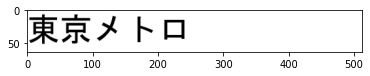

In [65]:
from PIL import ImageFont, ImageDraw, Image
# prediction_model = keras.models.load_model('model.h5')


def gen(text,h,w,fontSize):
    img = np.ones([h,w,3],dtype=np.uint8) *255
    fontpath ='./msg.ttf' # Windows10 だと C:\Windows\Fonts\ 以下にフォントがあります。
    b,g,r,a = 0,0,0,0 #B(青)・G(緑)・R(赤)・A(透明度)
    font = ImageFont.truetype(fontpath, fontSize) # フォントサイズが32
    img_pil = Image.fromarray(img) # 配列の各値を8bit(1byte)整数型(0～255)をPIL Imageに変換。
    draw = ImageDraw.Draw(img_pil) # drawインスタンスを生成
    message = text
    position = (0, 4) # テキスト表示位置
    draw.text(position, message, font = font , fill = (b, g, r, a) ) # drawにテキストを記載 fill:色 BGRA (RGB)
    img = np.array(img_pil) # PIL を配列に変換
    return img
img = gen('東京メトロ',64,512,50)
# img = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
plt.imshow(img)
img = img[np.newaxis,...].astype(np.float64) /255
preds = prediction_model.predict(img)
pred_texts = decode_batch_predictions(preds)

pred_texts